In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import scipy.stats
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter


Text(0, 0.5, 'Probability of Voting \n for Correct Project (%)')

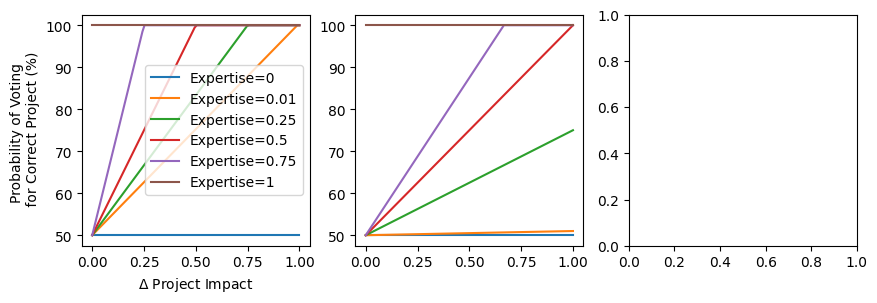

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))

project_impact_difference_vec = np.linspace(0, 1, 100)
expertise = [0, 0.01, 0.25, 0.5, 0.75, 1]

# plot the badgeholder expertise to voting mapping w/ linear trajectory
for e in expertise:
    if e == 0:
        th1 = 0.5 * np.ones_like(project_impact_difference_vec)
        th2 = th1
        th3 = th1
    elif e == 1:
        th1 = 1 * np.ones_like(project_impact_difference_vec)
        th2 = th1
        th3 = th1
    else:
        th1 = 0.5 + project_impact_difference_vec*0.5/(1-e)  # v1 -- too aggressive 
        th2 = e*project_impact_difference_vec + 0.5            # v2 -- slower growth
        # th3 = 
    
    th1 = np.clip(th1, 0, 1)
    th2 = np.clip(th2, 0, 1)
    
    ax[0].plot(project_impact_difference_vec, th1*100, label=f'Expertise={e}')
    ax[1].plot(project_impact_difference_vec, th2*100, label=f'Expertise={e}')
    # ax[2].plot(project_impact_difference_vec, th3*100, label=f'Expertise={e}')

ax[0].legend()
ax[0].set_xlabel(r'$\Delta$ Project Impact')
ax[0].set_ylabel('Probability of Voting \n for Correct Project (%)')

In [4]:
expertise_vec = np.linspace(0,1,11)
# expertise_vec = [1.0]

def expertise2alignment_carl(
    num_mc=100,
    n_projects=100,
    random_seed_start=123
):
    rng = np.random.default_rng(random_seed_start)
    
    expertise2ktaudist = {}
    for e in expertise_vec:
        inner_results = []
        for ii in range(num_mc):
            project_impact_vec = rng.permutation(np.linspace(0,1,n_projects))

            subjectivity_score = rng.uniform(e, 2-e, n_projects)
            personal_ratings = np.asarray(project_impact_vec*subjectivity_score)
            # personal_ratings = shuffle_with_rank_correlation(project_impact_vec, e)
            ktau = scipy.stats.kendalltau(project_impact_vec, personal_ratings).statistic
            inner_results.append(ktau)
        expertise2ktaudist[e] = np.asarray(inner_results)
    return expertise2ktaudist

def expertise2alignment_k2(
    num_mc=100,
    n_projects=100,
    random_seed_start=123
):
    rng = np.random.default_rng(random_seed_start)
    
    expertise2ktaudist = {}
    for e in expertise_vec:
        inner_results = []
        for ii in range(num_mc):
            true_project_impact_vec = rng.permutation(np.linspace(0,1,n_projects))
            true_project_impact_vec_sorted_ix = np.argsort(true_project_impact_vec)  # only for comparison purposes

            # in this approach, we do the following method of generating personal ratings:
            #  the expertise factor determines the probability that a particular index gets shuffled
            #  in the following manner.
            #  1. we create the ranking of each index according to the true project impact.
            #  2. if expertise is 1, it means perfect knowledge, so we keep the same order.
            #  3. if expertise is 0, we shuffle the whole array, which basically randomizes everything, which is the meaning for expertise that we want.
            #  4. for any value in general, we need to shuffle the array.  The following is a heuristic
            #     for how we do this:
            #     a - for each index of the array, we have a probability that it will be shuffled.
            #     b - to model expertise better, the probabilty that an index will be shuffled is proportional to its ranking
            #         lets start w/ a linear model
            #         p_shuffle = e * rank / total
            #     
            #     c - we then shuffle the array according to the probabilities.
            
            personal_ratings_ix = np.argsort(true_project_impact_vec)  # this is perfect rating
            p_shuffle_vec = np.zeros(len(personal_ratings_ix))
            for ii in range(len(personal_ratings_ix)):
                p_shuffle_vec[ii] = (1-e)      # currently, not dependent on the "true impact" of a project, but can be in the future
            # find which indices we should shuffle
            ix_to_shuffle = []
            for ii in range(len(p_shuffle_vec)):
                rv = rng.uniform(0,1)
                if rv < p_shuffle_vec[ii]:
                    ix_to_shuffle.append(ii)
            # shuffle the indices that need to be
            personal_ratings_ix[ix_to_shuffle] = rng.permutation(personal_ratings_ix[ix_to_shuffle])

            ktau = scipy.stats.kendalltau(true_project_impact_vec_sorted_ix, personal_ratings_ix).statistic
            inner_results.append(ktau)
        expertise2ktaudist[e] = np.asarray(inner_results)
    return expertise2ktaudist

In [5]:
df_carl = pd.DataFrame(expertise2alignment_carl(num_mc=100))
df_k2 = pd.DataFrame(expertise2alignment_k2(num_mc=100))

In [6]:
dff_carl = pd.melt(df_carl, var_name='Expertise', value_name='Rank Correlation')
dff_k2 = pd.melt(df_k2, var_name='Expertise', value_name='Rank Correlation')

/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_82560/1711089690.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/nz/szh1vbf12cd7rwgcnt99cwkc0000gn/T/ipykernel_82560/1711089690.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


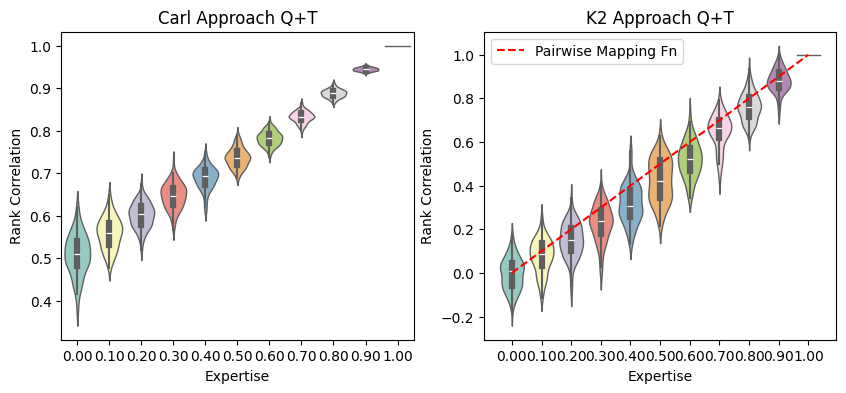

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

fmtr = lambda x: '%0.02f' % x

sns.violinplot(
    data=dff_carl, 
    x='Expertise', 
    y='Rank Correlation', 
    linewidth=1, 
    palette="Set3",
    formatter=fmtr,
    ax=ax[0]
)
ax[0].set_title('Carl Approach Q+T')
# ax[0].plot(range(len(expertise_vec)), 0.5*expertise_vec+0.5, linestyle='--', color='r')

sns.violinplot(
    data=dff_k2, 
    x='Expertise', 
    y='Rank Correlation', 
    linewidth=1, 
    palette="Set3",
    formatter=fmtr,
    ax=ax[1]
)
ax[1].set_title('K2 Approach Q+T')
ax[1].plot(range(len(expertise_vec)), expertise_vec, linestyle='--', color='r', 
           label='Pairwise Mapping Fn')
ax[1].legend()